# Schmidt et al., 2023: Calculations of time series

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from dask.distributed import Client
import os.path
import warnings
warnings.simplefilter('ignore')
from statsmodels.stats.weightstats import DescrStatsW
from gsw import SA_from_SP, p_from_z
from datetime import timedelta
from iav_AABW_functions import (
    shelf_mask_isobath, mask_from_polygon,
    fix_coordinates_of_ice_model, yearly_mean, yearly_sum,
    yearly_mean_different_start_1D,
    yearly_mean_different_start,
    select_bottom_values, mask_1000m_isobath_bottom,
    correlation_3D)

## plotting
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.ticker as mticker

In [2]:
plt.rcParams['figure.dpi'] = 96
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 3
plt.rcParams['hatch.color'] = 'k'
plt.rcParams["savefig.facecolor"] = 'white'

## Parameters

In [3]:
year_all = range(1958, 2019)
expt = '01deg_jra55v140_iaf_cycle3'
frequency = '1 monthly'

path_output = '/g/data/e14/cs6673/iav_AABW/data_iav_AABW_final/'
filename_timeseries = (
    'Timeseries_yearly_of_AABW_export_SWMT_salinity_taux_ice_' +
    expt + '_' + str(year_all[0]) + '-' + str(year_all[-2]) + '.nc')

In [4]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 48,Total memory: 180.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40457,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 180.00 GiB
Comm: tcp://127.0.0.1:37967,Total threads: 6
Dashboard: /proxy/38437/status,Memory: 22.50 GiB
Nanny: tcp://127.0.0.1:46627,


In [5]:
DSW_region = {
    'name': ['Weddell', 'Prydz', 'Adelie', 'Ross'],
    'name_long': ['Weddell Sea', 'Prydz Bay', 'Adélie Coast', 'Ross Sea'],
    'lon': [[-60, -35, -48, -62, -60],
            [48, 73, 74, 48, 48],
            [128-360, 152-360, 152-360, 128-360, 128-360],
            [185-360, 160-360, 164-360, 172-360, 185-360]],
    'lat': [[-71, -75, -78, -75, -71],
            [-65, -66.5, -69, -68, -65],
            [-64.5, -66, -69, -67.5, -64.5],
            [-78, -78, -73, -71.5, -78]],
    'sig0_bins': [27.92, 27.81, 27.81, 28],
    'ind_iso_min': [],
    'ind_iso_max': [],
    'sector': [[-65, 0, -78.5,  -62],
               [45, 80, -70, -60],
               [125-360, 165-360, -70, -60],
               [150-360, 220-360, -79, -65]],
    'mask_taux_lon': [[-58.5, -51, -36, -20, -20, -38, -58.5],
                      [35, 35, 80, 80, -280, -280, -230, -230],
                      [-225, -225, -210, -197, -197, -225],
                      [-171, -171, -140, -80, -80, -172]],
    'mask_taux_lat': [[-76.5, -72, -67.5, -69, -74, -78.8, -76.5],
                      [-65, -58, -58, -65, -65, -58, -58, -65],
                      [-67, -65, -65, -67.5, -71.8, -67],
                      [-79, -75, -67 , -67, -76, -79]]}

In [6]:
ds_yr_mean_months = xr.DataArray(
    np.transpose([[9, 8, 6, 8], [12, 12, 12, 12]]),
    coords={'area': DSW_region['name'],
            'months': ['start_month', 'number_of_months']})
ds_yr_mean_months.name = 'AABW_export'
ds_yr_mean_months = ds_yr_mean_months.to_dataset()
ds_yr_mean_months['SWMT'] = xr.DataArray(
    np.transpose([[1, 1, 1, 1], [12, 12, 12, 12]]),
    coords={'area': DSW_region['name'],
            'months': ['start_month', 'number_of_months']})
ds_yr_mean_months['salt'] = xr.DataArray(
    np.transpose([[8, 8, 8, 8], [3, 3, 3, 3]]),
    coords={'area': DSW_region['name'],
            'months': ['start_month', 'number_of_months']})
ds_yr_mean_months['taux'] = xr.DataArray(
    np.transpose([[1, 1, 4, 1], [6, 2, 6, 6]]),
    coords={'area': DSW_region['name'],
            'months': ['start_month', 'number_of_months']})
ds_yr_mean_months['ice_transp'] = xr.DataArray(
    np.transpose([[1, 1, 4, 1], [6, 6, 6, 6]]),
    coords={'area': DSW_region['name'],
            'months': ['start_month', 'number_of_months']})
ds_yr_mean_months['area_open_water'] = xr.DataArray(
    np.transpose([[4, 8, 7, 4], [3, 3, 3, 3]]),
    coords={'area': DSW_region['name'],
            'months': ['start_month', 'number_of_months']})
ds_yr_mean_months['salt_adv'] = xr.DataArray(
    [1, 6], dims='months')  # only in Ross Sea

## Load data

In [7]:
session = cc.database.create_session()
ht = cc.querying.getvar(expt, 'ht', session, n=1) 
ht = ht.sel(yt_ocean=slice(-90, -40))
land_mask = (ht*0).fillna(1)
ht_shelf = shelf_mask_isobath(ht.sel(yt_ocean=slice(-90, -60)))
area_t = cc.querying.getvar(expt, 'area_t', session, frequency='static',  n=1,
                            chunks={'yt_ocean': '100MB', 'xt_ocean': '100MB'})
area_u = cc.querying.getvar(expt, 'area_u', session, frequency='static',  n=1,
                            chunks={'yu_ocean': '100MB', 'xu_ocean': '100MB'})
xt_ocean = cc.querying.getvar(
    expt, 'xt_ocean', session, frequency='static', n=1)
yt_ocean = cc.querying.getvar(
    expt, 'yt_ocean', session, frequency='static', n=1).sel(yt_ocean=slice(-90, -60))
dzt = cc.querying.getvar(
    expt, 'dzt', session, frequency=frequency,
    chunks={'yt_ocean': '100MB', 'xt_ocean': '100MB'})
dzt_mask = dzt[0, :].drop('time').where(
    np.isnan(dzt[0, :, :, :].drop('time')) == True, 1)

In [8]:
for a, area_text in enumerate(DSW_region['name']):
    if a == 0:
        mask_DSW = mask_from_polygon(
            DSW_region['lon'][a], DSW_region['lat'][a], xt_ocean, yt_ocean).expand_dims(
            area=['Weddell'])
    else:
        mask_DSW = xr.concat((mask_DSW, mask_from_polygon(
            DSW_region['lon'][a], DSW_region['lat'][a],
            xt_ocean, yt_ocean).expand_dims(area=[area_text])), dim='area')
    mask_DSW = shelf_mask_isobath(mask_DSW)
mask_DSW = mask_DSW.where(mask_DSW == True)
mask_DSW = mask_DSW.where(land_mask == 0)
mask_DSW = mask_DSW .where(mask_DSW == 1, 0)

In [9]:
area_mask_DSW = mask_DSW * area_t * (land_mask.where(land_mask == 0)+1)

area_mask_DSW_3D = (mask_DSW * dzt_mask.isel(st_ocean=range(48)) *
                    area_t * (land_mask.where(land_mask == 0)+1))
area_mask_DSW_3D = (area_mask_DSW_3D / area_mask_DSW_3D.sum(
    ['xt_ocean', 'yt_ocean']).where(area_mask_DSW_3D.sum(
    ['xt_ocean', 'yt_ocean'])!= 0, 1)).compute()

## Transport across 1000-m isobath

In [10]:
# calculated and saved with iav_vol_trans_across_contour_execute.sh (this uses 
# iav_cross_contour_transport_calculation.py) and
# iav_vol_trans_across_contour_postprocessing.ipynb
transp1000m = xr.open_mfdataset(
    path_output + 'vol_trans_across_contour_' +
    expt + '_1d_*.nc', chunks='auto').vol_trans_across_contour
transp1000m = transp1000m.where(transp1000m != 0) * 1e-6  # in Sv

## AABW tracer at 1000-m isobath

In [11]:
%%time
# takes about 1.5 hours
filename_tracer = (
    'Passive_tracer_AABW_at_bottom_along_1000m_isobath_' +
    expt + '_' + frequency[0:3:2] + '_mean_' +
    str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')
if os.path.exists(path_output + filename_tracer) is True:
    ds_tracer = xr.open_dataset(path_output + filename_tracer)
    tracer_all = ds_tracer.passive_tracer_concentration
else:
    for a, area_text in enumerate(DSW_region['name']):
        print(a)
        tracer = cc.querying.getvar(
            expt, 'passive_' + area_text.lower(), session, frequency=frequency,
            start_time=str(year_all[0]) + '-01-01', end_time=str(year_all[-1]) + '-12-31',
            chunks={'yt_ocean': '100MB', 'xt_ocean': '100MB'})
        tracer = tracer.sel(yt_ocean=slice(-90, -59))
        tracer = yearly_mean(tracer).mean('time').compute()

        tracer = select_bottom_values(tracer, expt, session)
        tracer = mask_1000m_isobath_bottom(tracer)

        plt.figure()
        tracer.plot()
        plt.show()
        if a == 0:
            tracer_all = tracer.expand_dims(area=[area_text])
        else:
            tracer_all = xr.concat((tracer_all, tracer.expand_dims(
                area=[area_text])), dim='area')
    tracer_all.name = 'passive_tracer_concentration'
    tracer_all.attrs = {'units': '1', 
        'name_long': 'passive tracer concentration from each AABW formation ' +
        'region in bottom most grid cell along 1000-m isobath'}
    # because of a strange error about lon, lat being a MultiIndex
    # data is saved as new built dataset
    ds_tracer = tracer_all.drop({'lon', 'lat'}).to_dataset()
    ds_tracer['lon'] = xr.DataArray(tracer_all.lon.values, dims='contour_index')
    ds_tracer['lat'] = xr.DataArray(tracer_all.lat.values, dims='contour_index')
    comp = dict(zlib=True, complevel=5, shuffle=True)
    enc = {var: comp for var in ds_tracer.data_vars}
    ds_tracer.to_netcdf(path_output + filename_tracer, encoding=enc)

CPU times: user 11.3 ms, sys: 1.75 ms, total: 13.1 ms
Wall time: 39.6 ms


In [12]:
perc = .15
# only for a percentage above 13% the section along the isobath does not
# overlap for the four regions and we don't count transport twice 
for a, area_text in enumerate(DSW_region['name']):
    if area_text == 'Prydz':
        ind_iso_min = tracer_all.contour_index[3000:].where(tracer_all.sel(
            area=area_text) > perc).min().astype('int').values
        ind_iso_max = tracer_all.contour_index[:3000].where(tracer_all.sel(
            area=area_text) > perc).max().astype('int').values
    else:
        ind_iso_min = tracer_all.contour_index.where(tracer_all.sel(
            area=area_text) > perc).min().astype('int').values
        ind_iso_max = tracer_all.contour_index.where(tracer_all.sel(
            area=area_text) > perc).max().astype('int').values
    DSW_region['ind_iso_min'] += [np.int(ind_iso_min)]
    DSW_region['ind_iso_max'] += [np.int(ind_iso_max)]
print('DSW_region[ind_iso_min]:', DSW_region['ind_iso_min'])
print('DSW_region[ind_iso_max]:', DSW_region['ind_iso_max'])

DSW_region[ind_iso_min]: [3647, 5151, 581, 1141]
DSW_region[ind_iso_max]: [4307, 134, 960, 1830]


## AABW export across 1000-m isobath in AABW formation regions

In [13]:
"""transport in all density bins summed along section of
the 1000-m isobath close to each formation region"""
for a, area_text in enumerate(DSW_region['name']):
    if a == 0:
        transpDSWregion = transp1000m[
            :, :,DSW_region['ind_iso_min'][a]:DSW_region['ind_iso_max'][a]].sum(
            'contour_index').expand_dims(area=DSW_region['name'])
    elif area_text == 'Prydz':
        transpDSWregion[a, :, :] = (
            transp1000m[:, :, 0:DSW_region['ind_iso_max'][a]].sum('contour_index') +
            transp1000m[:, :, DSW_region['ind_iso_min'][a]:].sum('contour_index'))
    else:
        transpDSWregion[a, :, :] = transp1000m[
            :, :, DSW_region['ind_iso_min'][a]:DSW_region['ind_iso_max'][a]].sum(
            'contour_index')
transpDSWregion = transpDSWregion.compute()
transpDSWregion = transpDSWregion.where(transpDSWregion != 0)

In [14]:
"""mask for the AABW export (offshore transport in dense layers)"""
mask_AABW = transpDSWregion[:, :, ::-1].copy()

array_ind_iso = xr.DataArray(
    np.tile(np.arange(mask_AABW.isopycnal_bins.size), (mask_AABW.time.size, 1)),
    dims=['time', 'isopycnal_bins'])

for a in range(len(DSW_region['name'])):
    ind_max_transp = mask_AABW[a, :, :].argmax('isopycnal_bins')
    mask_AABW[a, :, :] = mask_AABW[a, :, :].where(
        np.isnan(mask_AABW[a, :, :]) == False, -1)
    
    # only keep values above (i.e. in lighter density bins) maximum positive transport
    # (the final mask will include values below the maximum positive transport)
    mask_AABW[a, :, :] = mask_AABW[a, :, :].where(array_ind_iso >= ind_max_transp)
    
    # index of first negative transport from bottom upwards
    ind_neg_transp = mask_AABW[a, :, :].where(mask_AABW[a, :, :] < 0, 1)
    ind_neg_transp = ind_neg_transp.where(ind_neg_transp == 1, -1)
    ind_neg_transp = ind_neg_transp.argmin('isopycnal_bins', skipna=False)
    ind_neg_transp = ind_neg_transp.where(
        ind_neg_transp != 0, mask_AABW.isopycnal_bins.size)
    
    mask_AABW[a, :, :] = mask_AABW[a, :, :].where(ind_neg_transp <= array_ind_iso)
    
    mask_AABW[a, :, :] = mask_AABW[a, :, :].where(np.isnan(mask_AABW[a, :, :]) == True, 0)
    mask_AABW[a, :, :] = mask_AABW[a, :, :].where(mask_AABW[a, :, :] == 0, 1)
    
mask_AABW = mask_AABW[:, :, ::-1]
mask_AABW = mask_AABW.where(np.isnan(transpDSWregion) == False)

In [15]:
"""smoothing of mask by filtering high frequency variability in
extent of density layer (especially in Prydz Bay)"""
# monthly mean of lighest density bin
mask_AABW_1D = (mask_AABW * mask_AABW.isopycnal_bins)
mask_AABW_1D = mask_AABW_1D.where(
    mask_AABW_1D != 0).min('isopycnal_bins')
mask_AABW_1D_m = mask_AABW_1D.resample(
    time='M', label='left', loffset=timedelta(days=15)).mean()

# resample to daily time series with the same value within each month
for a, area_text in enumerate(DSW_region['name']):
    if a == 0:
        mask_AABW_1D_m_daily = xr.DataArray(
            np.repeat(mask_AABW_1D_m[a, :], mask_AABW_1D_m.time.dt.days_in_month.values),
            dims='time', coords={'time': mask_AABW_1D.time, 'area': area_text})
    else:
        mask_AABW_1D_m_daily = xr.concat((mask_AABW_1D_m_daily, xr.DataArray(
            np.repeat(mask_AABW_1D_m[a, :], mask_AABW_1D_m.time.dt.days_in_month.values),
            dims='time', coords={'time': mask_AABW_1D.time, 'area': area_text})), dim='area')

diff_sig_m = -mask_AABW_1D_m.std('time')
mask_AABW_filtered = mask_AABW.where(
    mask_AABW.isopycnal_bins >= mask_AABW_1D_m_daily+diff_sig_m, 0)
mask_AABW_filtered = mask_AABW_filtered.where(
    np.isnan(mask_AABW) == False)

In [16]:
"""transport of AABW in all density bins (daily)"""
transpAABW = (
    transpDSWregion[:, :, ::-1] * mask_AABW_filtered[:, :, ::-1])
transpAABW = transpAABW.where(transpAABW != 0)

In [17]:
"""AABW export (monthly and yearly)"""
transpAABW_m = transpAABW.cumsum('isopycnal_bins')[:, :, ::-1].max(
    'isopycnal_bins').resample(
    time='M', label='left', loffset=timedelta(days=15)).mean()
transpAABW_m.name = 'AABW_export'
transpAABW_m.attrs = {
    'units': 'Sv'}
transpAABW_m.to_netcdf(
    path_output + 'AABW_export_across_1000m_isobath_' + expt + '_' +
    frequency[0:3:2] + '_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')

for a, area_text in enumerate(DSW_region['name']):
    if a == 0:
        AABW_export = yearly_mean_different_start_1D(
            transpAABW_m[a, :],
            start_month=ds_yr_mean_months.AABW_export[a, 0].values,
            num_months=ds_yr_mean_months.AABW_export[a, 1].values).expand_dims(
            area=[area_text])
    else:
        AABW_export = xr.concat((AABW_export, yearly_mean_different_start_1D(
            transpAABW_m[a, :],
            start_month=ds_yr_mean_months.AABW_export[a, 0].values,
            num_months=ds_yr_mean_months.AABW_export[a, 1].values).expand_dims(
            area=[area_text])), dim='area')
AABW_export.name = 'AABW_export'
AABW_export.attrs = {
    'units': 'Sv', 'time_average':
    'annual value starting in start_month and averaging over a certain number_of_months',
    'start_month': str(ds_yr_mean_months.AABW_export[:, 0].values),
    'number_of_months': str(ds_yr_mean_months.AABW_export[:, 1].values)}
ds_timeseries = AABW_export.to_dataset()

if os.path.exists(path_output + filename_timeseries) is False:
    ds_timeseries.to_netcdf(path_output + filename_timeseries)

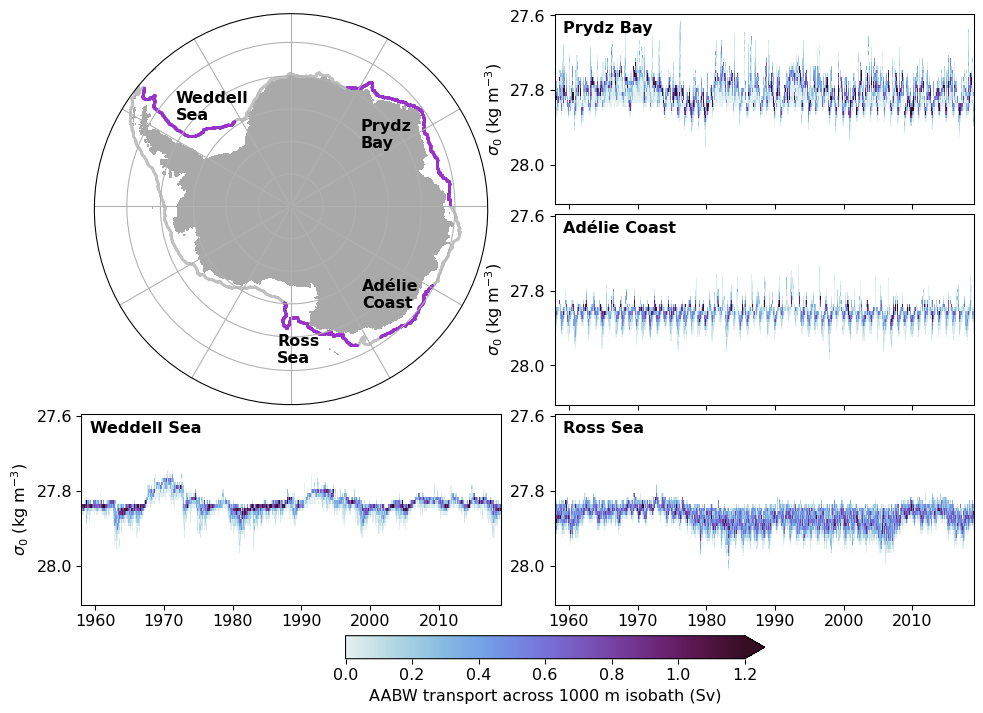

In [18]:
fig = plt.figure(figsize=(12, 8))
plt.subplots_adjust(hspace=.05, wspace=.13)

proj = ccrs.PlateCarree()

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax = plt.subplot(3, 2, (1, 3), projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)
gl = ax.gridlines(draw_labels=False)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))

ax.contourf(land_mask.xt_ocean.values,
            np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
            land_mask, colors='darkgrey', levels=[0.5, 2],
            transform=proj, rasterized=True, zorder=2)
plt.plot(ds_tracer.lon, ds_tracer.lat, '.', color='silver', markersize=1,
         transform=ccrs.PlateCarree())

for a, area_text in enumerate(DSW_region['name']):
    if area_text == 'Prydz':
        plt.plot(ds_tracer.lon[:DSW_region['ind_iso_max'][a]],
                 ds_tracer.lat[:DSW_region['ind_iso_max'][a]],
                 '.', color='darkorchid', markersize=2,
                 transform=ccrs.PlateCarree())
        plt.plot(ds_tracer.lon[DSW_region['ind_iso_min'][a]:],
                 ds_tracer.lat[DSW_region['ind_iso_min'][a]:],
                 '.', color='darkorchid', markersize=2,
                 transform=ccrs.PlateCarree())
    else:
        plt.plot(ds_tracer.lon[DSW_region['ind_iso_min'][a]:
                               DSW_region['ind_iso_max'][a]],
                 ds_tracer.lat[DSW_region['ind_iso_min'][a]:
                               DSW_region['ind_iso_max'][a]],
                 '.', color='darkorchid', markersize=2,
                 transform=ccrs.PlateCarree())
plt.text(-53, -68, 'Weddell\nSea', fontweight='bold', transform=ccrs.PlateCarree())
plt.text(50, -76, 'Prydz\nBay', fontweight='bold', transform=ccrs.PlateCarree())
plt.text(145, -71, 'Adélie\nCoast', fontweight='bold', transform=ccrs.PlateCarree())
plt.text(-175, -66, 'Ross\nSea', fontweight='bold', transform=ccrs.PlateCarree())

for a, area_text in enumerate(DSW_region['name']):
    if a == 0:
        plt.subplot(3, 2, 5)
    else:
        plt.subplot(3, 2, a*2)
    p = plt.pcolormesh(transpAABW.time.values, transpAABW.isopycnal_bins,
                       transpAABW[a, :, :].transpose(),
                       vmin=0, vmax=1.2, cmap=cmo.dense)
    plt.gca().invert_yaxis()
    if (a == 1) or (a == 2):
        plt.gca().set_xticklabels([])
    if a < 3:
        plt.ylabel('$\sigma_{0}$ (kg m$^{-3}$)')
    plt.text(.02, .9, DSW_region['name_long'][a], fontweight='bold',
             transform=plt.gca().transAxes)

pos = plt.gca().get_position()
cax = plt.axes([pos.xmin-.5*(pos.xmax-pos.xmin), pos.ymin-0.07,
                (pos.xmax-pos.xmin), 0.03])
cb = plt.colorbar(p, orientation='horizontal', cax=cax, extend='max')
cb.ax.set_xlabel('AABW transport across 1000 m isobath (Sv)')

plt.show()

In [19]:
t, sig0_bins  = xr.broadcast(transpAABW, transpAABW.isopycnal_bins)
sig0_bins = sig0_bins.transpose('area', 'time', 'isopycnal_bins')
transpAABW_sig0 = (sig0_bins * (transpAABW / transpAABW.sum(
    ['time', 'isopycnal_bins']))).sum(['time', 'isopycnal_bins'])
print('mean and standard deviation (transport weighted) density of AABW export')
for a, area_text in enumerate(DSW_region['name']):
    transpAABW_noNaN = transpAABW[a, :, :].values.flatten()
    sig0_bins_noNaN = sig0_bins[a, :].values.flatten()[~np.isnan(transpAABW_noNaN)]
    transpAABW_noNaN = transpAABW_noNaN[~np.isnan(transpAABW_noNaN)]
    std = DescrStatsW(sig0_bins_noNaN, weights=transpAABW_noNaN, ddof=1).std

    print(area_text + ': '  + str(np.round(transpAABW_sig0[a].values, 4)) + '+-' +
          str(np.round(std, 4)) + ' kg/m^3 (' +
          str(np.round(DSW_region['sig0_bins'][a] - transpAABW_sig0[a].values, 4)) +
          ' lighter than density of SWMT)')

mean and standard deviation (transport weighted) density of AABW export
Weddell: 27.84+-0.0225 kg/m^3 (0.08 lighter than density of SWMT)
Prydz: 27.8005+-0.0365 kg/m^3 (0.0095 lighter than density of SWMT)
Adelie: 27.8607+-0.0221 kg/m^3 (-0.0507 lighter than density of SWMT)
Ross: 27.8722+-0.0257 kg/m^3 (0.1278 lighter than density of SWMT)


## Surface water mass transformation (SWMT)

In [20]:
%%time
"""this cell only works with kernel analysis3-22.10,
    newer kernels produce wrong results"""
# takes about 40 minutes
# one file with time mean only for the 3 density bins of AABW formation regions
# to plot in Fig. 1a
filename = ('SWMT_for_sig0_in_AABW_formation_region_' + expt +
            '_' + frequency[0:3:2] + '_yearly_mean_' + str(year_all[0]) +
            '-' + str(year_all[-1]) + '.nc')
if os.path.exists(path_output + filename) is False:
    ds_SWMT = xr.open_mfdataset(
        path_output + 'SWMT_for_sig0_27-2_28-1_' + expt + '_' +
        frequency[0:3:2] + '_????.nc',
        chunks={'xt_ocean': '500MB', 'yt_ocean': '500MB'})
    ds_SWMT['isopycnal_bins'] = ds_SWMT.isopycnal_bins - .5*(
        ds_SWMT.isopycnal_bins[1]-ds_SWMT.isopycnal_bins[0])  # upper boundary of sig0 bin
    for a in [1, 0, 3]:
        ds_SWMT_sig0_bin = ds_SWMT.sel(
            isopycnal_bins=DSW_region['sig0_bins'][a], method='nearest')
        if a == 1:
            ds_SWMT_mean = yearly_mean(ds_SWMT_sig0_bin).assign_coords(
                isopycnal_bins=DSW_region['sig0_bins'][a]).compute()
        else:
            ds_SWMT_mean = xr.concat(
                (ds_SWMT_mean, yearly_mean(ds_SWMT_sig0_bin).assign_coords(
                isopycnal_bins=DSW_region['sig0_bins'][a]).compute()),
                dim='isopycnal_bins')
    ds_SWMT_mean.attrs = ds_SWMT.attrs
    enc = {'binned_salt_transformation':
           {'chunksizes': (1, 10, 510, 3600),
            'zlib': True, 'complevel': 5, 'shuffle': True},
          'binned_heat_transformation':
           {'chunksizes': (1, 10, 510, 3600),
            'zlib': True, 'complevel': 5, 'shuffle': True}}
    ds_SWMT_mean.to_netcdf(path_output + filename, encoding=enc)

CPU times: user 612 µs, sys: 220 µs, total: 832 µs
Wall time: 651 µs


In [21]:
# one file, but same temporal resolution
filename = ('SWMT_in_AABW_formation_region_for_sig0_27-2_28-1_' +
            expt + '_' + frequency[0:3:2] + '_' + str(year_all[0]) +
            '-' + str(year_all[-1]) + '.nc')
if os.path.exists(path_output + filename) is False:
    ds_SWMT = xr.open_mfdataset(
        path_output + 'SWMT_in_AABW_formation_region_for_sig0_27-2_28-1_' +
        expt + '_' + frequency[0:3:2] + '*.nc')
    comp = dict(zlib=True, complevel=5, shuffle=True)
    enc = {var: comp for var in ds_SWMT.data_vars}
    ds_SWMT.to_netcdf(path_output + filename, encoding=enc)
    for year in year_all:
        os.remove(
            path_output + 'SWMT_in_AABW_formation_region_for_sig0_27-2_28-1_' +
            expt + '_' + frequency[0:3:2] + '_' + str(year) + '.nc')

In [22]:
# yearly time series of SWMT
ds_SWMT = xr.open_mfdataset(
    path_output + 'SWMT_in_AABW_formation_region_for_sig0_27-2_28-1_' +
    expt + '_' + frequency[0:3:2] + '_' + str(year_all[0]) +
    '-' + str(year_all[-1]) + '.nc')
ds_SWMT['isopycnal_bins'] = ds_SWMT.isopycnal_bins - .5*(
    ds_SWMT.isopycnal_bins[1]-ds_SWMT.isopycnal_bins[0])  # upper boundary of sig0 bin
SWMT = (ds_SWMT.binned_heat_transformation_in_AABW_region +
        ds_SWMT.binned_salt_transformation_in_AABW_region)
SWMT = yearly_mean(SWMT)
SWMT = SWMT.sel(isopycnal_bins=xr.DataArray(DSW_region['sig0_bins'], dims='AREA'),
                area=xr.DataArray(DSW_region['name'], dims='AREA'),
                method='nearest').rename({'AREA': 'area'}).transpose()
# remove last year (i.e. 2018) to match length of time series of other variables
SWMT = SWMT.sel(time=year_all[:-1])

SWMT.name = 'SWMT'
SWMT.attrs = {
    'units': 'Sv', 'time_average':
    'annual value starting in start_month and averaging over a certain number_of_months',
    'start_month': str(ds_yr_mean_months.SWMT[:, 0].values),
    'number_of_months': str(ds_yr_mean_months.SWMT[:, 1].values)}

SWMT.to_netcdf(path_output + filename_timeseries, mode='a')

In [23]:
%%time
# cut out SWMT for sig_0>27.2 in DSW formation regions
# to plot maps of SWMT for certain months
# takes about 7 hours
filename = ('SWMT_in_Ross_for_sig0_27-6_28-1_' + expt + '_' +
            frequency[0:3:2] + '_' + str(year_all[0]) +
            '-' + str(year_all[-1]) + '.nc')
if os.path.exists(path_output + filename) is False:
    for a, area_text in enumerate(DSW_region['name']):
        print(area_text)
        for year in range(1958, 2019):
            ds_SWMT = xr.open_dataset(
                path_output + 'SWMT_for_sig0_27-2_28-1_' + expt + '_' +
                frequency[0:3:2] + '_' + str(year) + '.nc')
            ds_SWMT = ds_SWMT.sel(isopycnal_bins=slice(27.6, None))
            if area_text == 'Weddell':
                ds_SWMT = ds_SWMT.sel(xt_ocean=slice(-65, -32),
                                      yt_ocean=slice(-78.5,  -69))
            elif area_text == 'Prydz':
                ds_SWMT = ds_SWMT.sel(xt_ocean=slice(45, 75),
                                      yt_ocean=slice(-70, -64))
            elif area_text == 'Adelie':
                ds_SWMT = ds_SWMT.sel(xt_ocean=slice(125-360, 155-360),
                                      yt_ocean=slice(-70, -64))
            elif area_text == 'Ross':
                ds_SWMT = ds_SWMT.sel(xt_ocean=slice(160-360, 190-360),
                                      yt_ocean=slice(-79, -70))

            ds_SWMT.to_netcdf(
                path_output + 'SWMT_in_' + area_text + '_for_sig0_27-6_28-1_' +
                expt + '_' + frequency[0:3:2] + '_' + str(year) + '.nc')
            del ds_SWMT
        filename = ('SWMT_in_' + area_text + '_for_sig0_27-6_28-1_' +
                    expt + '_' + frequency[0:3:2] + '_' + str(year_all[0]) +
                    '-' + str(year_all[-1]) + '.nc')
        if os.path.exists(path_output + filename) is False:
            ds_SWMT = xr.open_mfdataset(
                path_output + 'SWMT_in_' + area_text + '_for_sig0_27-6_28-1_' +
                expt + '_' + frequency[0:3:2] + '_????.nc')
            enc = {'binned_salt_transformation':
                   {'chunksizes': (183, 51, 50, 50),
                    'zlib': True, 'complevel': 5, 'shuffle': True},
                   'binned_heat_transformation':
                   {'chunksizes': (183, 51, 50, 50),
                    'zlib': True, 'complevel': 5, 'shuffle': True}}
            ds_SWMT.to_netcdf(path_output + filename, encoding=enc)
            for year in year_all:
                os.remove(
                    path_output + 'SWMT_in_' + area_text + '_for_sig0_27-6_28-1_' +
                    expt + '_' + frequency[0:3:2] + '_' + str(year) + '.nc')

CPU times: user 1.34 ms, sys: 0 ns, total: 1.34 ms
Wall time: 780 µs


## Salinity in AABW formation region

In [24]:
%%time
# Cut out salinity in sectors of AABW formation, convert to absolute salinity and save.
# This takes about 2.5 hours
filename = ('salt_absolute_Ross_' + expt + '_' + frequency[0:3:2] +
            '_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')
if os.path.exists(path_output + filename) is False:
    for a, area_text in enumerate(DSW_region['name']):
        print(a)
        salt_psu = cc.querying.getvar(
            expt, 'salt', session, frequency=frequency,
            start_time=str(year_all[0]) + '-01-01',
            end_time = str(year_all[-1]) + '-12-31',
            chunks={'yt_ocean': '200MB', 'xt_ocean': '200MB'})
        salt_psu = salt_psu.sel(
            xt_ocean=slice(DSW_region['sector'][a][0], DSW_region['sector'][a][1]),
            yt_ocean=slice(DSW_region['sector'][a][2], DSW_region['sector'][a][3])).isel(
            st_ocean=range(48)).compute()

        # convert to absolute salinity
        depth = - salt_psu.st_ocean.values
        depth = xr.DataArray(depth, coords = [salt_psu.st_ocean], dims=['st_ocean'])
        pressure = xr.DataArray(p_from_z(depth, salt_psu.yt_ocean), 
                                coords=[salt_psu.st_ocean, salt_psu.yt_ocean], 
                                dims=['st_ocean', 'yt_ocean'], 
                                name='pressure', attrs={'units':'dbar'})
        salt = xr.DataArray(SA_from_SP(
            salt_psu[:100, :, :, :], pressure, salt_psu.xt_ocean, salt_psu.yt_ocean), 
            coords = [salt_psu[:100, :, :, :].time, salt_psu.st_ocean,
                      salt_psu.yt_ocean, salt_psu.xt_ocean], 
            dims = ['time', 'st_ocean','yt_ocean', 'xt_ocean'], 
            name = 'salt', 
            attrs = {'units':'Absolute Salinity (g/kg)'})

        for l in range(100, len(salt_psu.time), 100):
            print(l)
            salt = xr.concat((salt, xr.DataArray(SA_from_SP(
                salt_psu[l:l+100, :, :, :], pressure, salt_psu.xt_ocean, salt_psu.yt_ocean), 
                coords=[salt_psu[l:l+100, :, :, :].time, salt_psu.st_ocean,
                          salt_psu.yt_ocean, salt_psu.xt_ocean], 
                dims=['time', 'st_ocean','yt_ocean', 'xt_ocean'], 
                name='salt', 
                attrs={'units':'Absolute Salinity (g/kg)'})), dim='time')
        filename = (
            'salt_absolute_' + area_text + '_' + expt + '_' + frequency[0:3:2] +
            '_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')
        enc = {'salt': {'chunksizes': (183, 48, 50, 50),
                'zlib': True, 'complevel': 5, 'shuffle': True}}
        salt.to_netcdf(path_output + filename, encoding=enc)

CPU times: user 1.25 ms, sys: 0 ns, total: 1.25 ms
Wall time: 1.01 ms


In [25]:
%%time
# calculate mean in x and y in all of the above saved files and save to
# one datset for Hovmöller plots
# This takes about 1 hour
filename = ('salt_absolute_spatial_mean_in_each_AABW_formation_region_' +
            expt + '_' + frequency[0:3:2] + '_' + str(year_all[0]) + '-' +
            str(year_all[-1]) + '.nc')
if os.path.exists(path_output + filename) is False:
    for a, area_text in enumerate(DSW_region['name']):
        print(a)
        salt_abs = xr.open_dataarray(
            path_output + 'salt_absolute_' + area_text + '_' + expt + '_' +
            frequency[0:3:2] + '_' + str(year_all[0]) + '-' + str(year_all[-1]) +
            '.nc', chunks={'time': '500MB', 'st_ocean': '500MB'})
        if a == 0:
            salt_DSW_mean = (salt_abs * area_mask_DSW_3D.isel(area=a)).sum(
                ['xt_ocean', 'yt_ocean']).compute()
        else:
            salt_DSW_mean = xr.concat(
                (salt_DSW_mean, (salt_abs * area_mask_DSW_3D.isel(area=a)).sum(
                    ['xt_ocean', 'yt_ocean']).compute()),
                dim='area')
    salt_DSW_mean = salt_DSW_mean.where(salt_DSW_mean != 0)
    salt_DSW_mean.name = 'salt'
    salt_DSW_mean.attrs = {'units': 'Absolute Salinity (g/kg)'}
    enc = {'salt': {'zlib': True, 'complevel': 5, 'shuffle': True}}
    salt_DSW_mean.to_netcdf(path_output + filename, encoding=enc)

CPU times: user 1.16 ms, sys: 376 µs, total: 1.53 ms
Wall time: 1.1 ms


In [26]:
%%time
# Cut out volume in sectors of AABW formation to calculate volume weighted
# mean salinity and save.
# This takes about 1 hour
filename = ('volume_Ross_' + expt + '_' + frequency[0:3:2] +
            '_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')
if os.path.exists(path_output + filename) is False:
    volume_mask_DSW_4D = (mask_DSW * dzt.isel(st_ocean=range(48)) *
                          area_t * (land_mask.where(land_mask == 0)+1))
    for a, area_text in enumerate(DSW_region['name']):
        print(a)
        volume  = volume_mask_DSW_4D.sel(
            area=area_text,
            xt_ocean=slice(DSW_region['sector'][a][0], DSW_region['sector'][a][1]),
            yt_ocean=slice(DSW_region['sector'][a][2], DSW_region['sector'][a][3])).isel(
            st_ocean=range(48))
        volume = volume.where(volume != 0).compute()
        volume = volume.transpose('time', 'st_ocean', 'yt_ocean', 'xt_ocean')
        volume.name = 'volume'
        volume.attrs = {'units': 'm3'}
        volume.to_netcdf(
            path_output + 'volume_' + area_text + '_' + expt + '_' + frequency[0:3:2] +
            '_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc',
            encoding={'volume': {'chunksizes': (100, 48, 100, 100),
                                 'zlib': True, 'complevel': 5, 'shuffle': True}})

CPU times: user 935 µs, sys: 0 ns, total: 935 µs
Wall time: 686 µs


In [27]:
%%time
# calculate volume weighted mean (in x, y, z) for depth 0-300m
# this takes about 5 minutes
filename = ('salt_absolute_volume_weighted_mean_0-300m_in_' +
            'each_AABW_formation_region_' + expt + '_' + frequency[0:3:2] +
            '_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')
if os.path.exists(path_output + filename) is False:
    for a, area_text in enumerate(DSW_region['name']):
        print(a)
        volume = xr.open_dataarray(
            path_output + 'volume_' + area_text + '_' + expt + '_' + frequency[0:3:2] +
            '_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc', chunks=100)
        salt_abs = xr.open_dataarray(
            path_output + 'salt_absolute_' + area_text + '_' + expt + '_' +
            frequency[0:3:2] + '_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc',
            chunks=100)

        volume_sum = (volume.sel(st_ocean=slice(300)) /
                      volume.sel(st_ocean=slice(300)).sum(
                          ['xt_ocean', 'yt_ocean', 'st_ocean']))
        salt_DSW_mean = (salt_abs.sel(st_ocean=slice(300)) * volume_sum).sum(
            ['xt_ocean', 'yt_ocean', 'st_ocean']).compute()
        salt_DSW_mean = salt_DSW_mean.where(salt_DSW_mean != 0).transpose()
        if a == 0:
            salt_DSW_mean_all = salt_DSW_mean.expand_dims(area=[area_text])
        else:
            salt_DSW_mean_all = xr.concat(
                (salt_DSW_mean_all, salt_DSW_mean.expand_dims(area=[area_text])),
                dim='area')

    salt_DSW_mean_all.name = 'salt'
    salt_DSW_mean_all.attrs = {'units': 'Absolute Salinity (g/kg)',
                               'st_ocean': '0.5 to 282.0'}
    enc = {'salt': {'zlib': True, 'complevel': 5, 'shuffle': True}}
    salt_DSW_mean_all.to_netcdf(path_output + filename, encoding=enc)

CPU times: user 1.34 ms, sys: 0 ns, total: 1.34 ms
Wall time: 1.16 ms


In [28]:
# time series of salinity at 0-300m in Aug-Oct
salt = xr.open_dataarray(
    path_output + 'salt_absolute_volume_weighted_mean_0-300m_in_each_AABW_formation_region_' +
    expt + '_' + frequency[0:3:2] + '_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')
salt_yr = yearly_mean(salt.sel(time=salt.time.dt.month.isin([8, 9, 10])))

# remove last year (i.e. 2018) to match length of time series of other variables
salt_yr = salt_yr.sel(time=year_all[:-1])
salt_yr.name = 'salt'
salt_yr.attrs = {
    'units': 'g/kg', 'time_average':
    'annual value starting in start_month and averaging over a certain number_of_months',
    'start_month': str(ds_yr_mean_months.salt[:, 0].values),
    'number_of_months': str(ds_yr_mean_months.salt[:, 1].values),
    'spatial_average': 'volume weighted mean in upper 300 m in DSW formation region'}
salt_yr.to_netcdf(path_output + filename_timeseries, mode='a')

## Zonal wind upstream of AABW formation region

In [29]:
taux = cc.querying.getvar(
    expt, 'tau_x', session, start_time=str(year_all[0]) + '-01-01',
    end_time = str(year_all[-1]) + '-12-31',
    chunks={'yu_ocean': '200MB', 'xu_ocean': '200MB'})
taux = taux.sel(yu_ocean=slice(-90, -50)).compute()

In [30]:
%%time
# correlation of taux with S in DSW region
# this takes about 7 minutes
filename = ('Correlation_zonal_wind_and_salinity_in_' +
            'AABW_formation_region_' + expt + '_' +
            frequency[0:3:2] + '_' + str(year_all[0]) +
            '-' + str(year_all[-1]) + '.nc')
if os.path.exists(path_output + filename) is False:
    salt_DSW = xr.open_dataset(path_output + filename_timeseries).salt
    for a, area_text in enumerate(DSW_region['name']):
        if a == 0:
            taux_cor, taux_pval = correlation_3D(
                salt_DSW[a, :], yearly_mean_different_start(
                    taux.rename({'xu_ocean': 'xt_ocean', 'yu_ocean': 'yt_ocean'}),
                    start_month=ds_yr_mean_months.taux[a, 0].values,
                    num_months=ds_yr_mean_months.taux[a, 1].values)[:60, :, :],
                dims='time')
        else:
            taux_cor_temp, taux_pval_temp = correlation_3D(
                salt_DSW[a, :], yearly_mean_different_start(
                    taux.rename({'xu_ocean': 'xt_ocean', 'yu_ocean': 'yt_ocean'}),
                    start_month=ds_yr_mean_months.taux[a, 0].values,
                    num_months=ds_yr_mean_months.taux[a, 1].values)[:60, :, :],
                dims='time')
            taux_cor = xr.concat((taux_cor, taux_cor_temp), dim='area')
            taux_pval = xr.concat((taux_pval, taux_pval_temp), dim='area')

    taux_cor.name = 'correlation'
    ds_taux_cor = taux_cor.to_dataset()
    ds_taux_cor['p_value'] = taux_pval
    ds_taux_cor.attrs = {
        'name_long': 'spatial correlation and p-value of the salinity in the ' +
        'AABW formation region (1D) and the zonal wind stress (2D)',
        'units': '1',
        'time_average': 'annual value starting in start_month and averaging ' +
        'over a certain number_of_months'}
    enc = {'correlation': {'chunksizes': (4, 665, 3600),
                           'zlib': True, 'complevel': 5, 'shuffle': True},
           'p_value': {'chunksizes': (4, 665, 3600),
                       'zlib': True, 'complevel': 5, 'shuffle': True}}
    ds_taux_cor.to_netcdf(path_output + filename, encoding=enc)

CPU times: user 860 µs, sys: 374 µs, total: 1.23 ms
Wall time: 2.44 ms


In [31]:
for a, area_text in enumerate(DSW_region['name']):
    if a == 0:
        mask_taux = mask_from_polygon(
            DSW_region['mask_taux_lon'][a], DSW_region['mask_taux_lat'][a],
            xt_ocean, yt_ocean).expand_dims(area=['Weddell'])
    else:
        mask_taux = xr.concat((mask_taux, mask_from_polygon(
            DSW_region['mask_taux_lon'][a], DSW_region['mask_taux_lat'][a],
            xt_ocean, yt_ocean).expand_dims(area=[area_text])), dim='area')
mask_taux = mask_taux.where(mask_taux == True)

In [32]:
area_mask_taux = mask_taux * area_t
area_mask_taux = area_mask_taux / area_mask_taux.sum(['xt_ocean', 'yt_ocean'])
area_mask_taux = area_mask_taux.compute()

In [33]:
%%time
# mean in the masked areas
# takes 7 mins
taux_mask = (area_mask_taux * taux.sel(yu_ocean=slice(-90, -60)).rename(
    {'xu_ocean': 'xt_ocean', 'yu_ocean': 'yt_ocean'}).drop(
    {'xt_ocean', 'yt_ocean'})).sum(['xt_ocean', 'yt_ocean']).compute()

CPU times: user 1min, sys: 7min 23s, total: 8min 23s
Wall time: 7min 41s


In [34]:
# yearly time series of zonal wind upstream of AABW formation region
for a, area_text in enumerate(DSW_region['name']):
    if a == 0:
        taux_mask_yr = yearly_mean_different_start_1D(
            taux_mask[a, :],
            start_month=ds_yr_mean_months.taux[a, 0].values,
            num_months=ds_yr_mean_months.taux[a, 1].values).expand_dims(
            area=[area_text])
    else:
        taux_mask_yr = xr.concat((taux_mask_yr, yearly_mean_different_start_1D(
            taux_mask[a, :],
            start_month=ds_yr_mean_months.taux[a, 0].values,
            num_months=ds_yr_mean_months.taux[a, 1].values).expand_dims(
            area=[area_text])), dim='area')
# remove last year (i.e. 2018) to match length of time series of other variables
taux_mask_yr = taux_mask_yr.sel(time=year_all[:-1])

taux_mask_yr.name = 'taux'
taux_mask_yr.attrs = {
    'units': 'N/m^2', 'time_average':
    'annual value starting in start_month and averaging over a certain number_of_months',
    'start_month': str(ds_yr_mean_months.taux[:, 0].values),
    'number_of_months': str(ds_yr_mean_months.taux[:, 1].values),
    'spatial_average': 'horizontal mean upstream of DSW formation region'}
taux_mask_yr.to_netcdf(path_output + filename_timeseries, mode='a')

### Zonal wind in Prydz Bay closer to AABW formation region

In [35]:
%%time
mask_taux_Prydz = mask_from_polygon(
    [65, 65, 80, 80, -280, -280, 112-360, 112-360],
    [-69, -62.5, -62.5, -69, -69, -62.5, -62.5, -69], xt_ocean, yt_ocean)
mask_taux_Prydz = mask_taux_Prydz.where(mask_taux_Prydz == True)

area_mask_taux_Prydz = mask_taux_Prydz * area_t
area_mask_taux_Prydz = area_mask_taux_Prydz / area_mask_taux_Prydz.sum(['xt_ocean', 'yt_ocean'])
area_mask_taux_Prydz = area_mask_taux_Prydz.compute()

# mean in the new masked area in Prydz
taux_mask_Prydz = (area_mask_taux_Prydz * taux.sel(yu_ocean=slice(-90, -60)).rename(
    {'xu_ocean': 'xt_ocean', 'yu_ocean': 'yt_ocean'}).drop({'xt_ocean', 'yt_ocean'})).sum(
    ['xt_ocean', 'yt_ocean']).compute()

taux_Prydz = yearly_mean_different_start_1D(
    taux_mask_Prydz, start_month=1, num_months=6)

# remove last year (i.e. 2018) to match length of time series of other variables
taux_Prydz = taux_Prydz.sel(time=year_all[:-1])
taux_Prydz.name = 'taux_Prydz'
taux_Prydz.attrs = {
    'area': 'Prydz',
    'units': 'N/m^2', 'time_average':
    'annual value starting in start_month and averaging over a certain number_of_months',
    'start_month': str(1),
    'number_of_months': str(6),
    'spatial_average': 'horizontal mean in region closer to DSW formation region'}
taux_Prydz.to_netcdf(path_output + filename_timeseries, mode='a')

CPU times: user 7.36 s, sys: 7.55 s, total: 14.9 s
Wall time: 21.9 s


## Ice transport into AABW formation region

In [36]:
%%time
# This takes about 30 min
filename = ('ice_transp_across_section_east_of_AABW_formation_regions_' + expt +
            '_1d_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')
if os.path.exists(path_output + filename) is False:
    time_daily = cc.querying.getvar(
            expt, 'surface_salt', session, frequency='1 daily').time
    ds_ice_transp = xr.Dataset(data_vars={
        'lon': (['area'], np.array([-30, 95-360, 159-360, -165])),
        'lat_min': (['area'], np.array([-76.8, -66.6, -69.5, -78.7])),
        # lat_max = lat_min + 3
        'ice_transport': (['area', 'time', 'yu_ocean'], np.ones((4, len(time_daily), 70)),
                          {'units': 'm3/s',
                           'direction': 'positive westwards into AABW formation region'}),
        'yu': (['area', 'yu_ocean'], np.ones((4, 70)))},
                               coords={'time': time_daily, 'area': DSW_region['name']})

    for a in range(4):
        print(a)
        dyu = cc.querying.getvar(expt, 'dyu', session, n=1,
                                 chunks={'yu_ocean': '100MB', 'xu_ocean': '100MB'})

        # Note ice_u is positioned on northeastern corner of t-cell.
        ice_u = cc.querying.getvar(
            expt, 'uvel', session, frequency='1 daily', decode_coords=False,
            chunks={'nj': '100MB', 'ni': '100MB'})
        ice_thick = cc.querying.getvar(
            expt, 'hi', session, frequency='1 daily', decode_coords=False,
            chunks={'nj': '100MB', 'ni': '100MB'})
        (ice_thick, ice_u) = tuple(map(fix_coordinates_of_ice_model, (ice_thick, ice_u),
                                       (area_t, area_u)))

        # select section
        dyu = dyu.sel(xu_ocean=ds_ice_transp.lon[a], method='nearest').sel(
            yu_ocean=slice(ds_ice_transp.lat_min[a], None)).isel(
            yu_ocean=slice(0, 70))
        ice_u = ice_u.sel(xu_ocean=ds_ice_transp.lon[a], method='nearest').sel(
            yu_ocean=slice(ds_ice_transp.lat_min[a], None)).isel(
            yu_ocean=slice(0, 70)).compute()
        lat_min_grid_T = ice_u.yu_ocean[0] - (ice_u.yu_ocean[1] - ice_u.yu_ocean[0])/2
        ice_thick = ice_thick.sel(xt_ocean=slice(ds_ice_transp.lon[a]-0.1, None)).sel(
            yt_ocean=slice(lat_min_grid_T, None)).isel(
            xt_ocean=slice(0, 2), yt_ocean=slice(0, 71)).compute()
        assert ice_thick.xt_ocean.mean('xt_ocean') == ice_u.xu_ocean, "Not the same longitude"
        assert len(ice_thick.xt_ocean) == 2, "Not the right amount of grid cells in zonal direction"
        assert ice_thick.yt_ocean[:2].mean('yt_ocean') == ice_u.yu_ocean[0], "Not the same minimum latitude"
        # interpolate ice_thick from T grid point to U grid point as defined on a B-grid
        ice_thick = ice_thick.mean('xt_ocean').drop('yt_ocean').rename({'yt_ocean': 'yu_ocean'})
        ice_thick = (ice_thick[:, :-1] + ice_thick[:, 1:])/ 2

        """ice volume transport"""
        ice_transp_data = ice_thick * dyu * ice_u * -1. # positive westwards into the region
        ds_ice_transp['ice_transport'][a, :, :] = ice_transp_data
        ds_ice_transp['yu'][a, :] = ice_transp_data.yu_ocean
        
    ds_ice_transp.attrs = {
        'direction': 'positive westwards into DSW region',
        'units': 'm3/s'}
    enc = {'ice_transport': {'zlib': True, 'complevel': 5, 'shuffle': True}}
    ds_ice_transp.to_netcdf(path_output + filename, encoding=enc)

CPU times: user 213 µs, sys: 919 µs, total: 1.13 ms
Wall time: 899 µs


In [37]:
ds_ice_transp = xr.open_dataset(
    path_output + 'ice_transp_across_section_east_of_AABW_formation_regions_' +
    expt + '_1d_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')

ice_transp = ds_ice_transp.ice_transport.sum('yu_ocean')
ice_transp = ice_transp.resample(
    time="1MS", label='left', loffset=timedelta(days=15)).mean(dim="time")

for a, area_text in enumerate(DSW_region['name']):
    if a == 0:
        ice_transp_yr = yearly_mean_different_start_1D(
            ice_transp[a, :], start_month=ds_yr_mean_months.ice_transp[a, 0].values,
            num_months=ds_yr_mean_months.ice_transp[a, 1].values).expand_dims(area=[area_text])
    else:
        ice_transp_yr = xr.concat((ice_transp_yr, yearly_mean_different_start_1D(
            ice_transp[a, :], start_month=ds_yr_mean_months.ice_transp[a, 0].values,
            num_months=ds_yr_mean_months.ice_transp[a, 1].values).expand_dims(
            area=[area_text])), dim='area')

# remove last year (i.e. 2018) to match length of time series of other variables
ice_transp_yr = ice_transp_yr.sel(time=year_all[:-1])
ice_transp_yr  = ice_transp_yr.assign_coords({'lon': ds_ice_transp.lon,
                                              'lat_min': ds_ice_transp.lat_min})
ice_transp_yr.name = 'ice_transport'
ice_transp_yr.attrs = {
    'direction': 'positive westwards into DSW formation region',
    'units': 'm3/s', 'time_average':
    'annual value starting in start_month and averaging over a certain number_of_months',
    'start_month': str(ds_yr_mean_months.ice_transp[:, 0].values),
    'number_of_months': str(ds_yr_mean_months.ice_transp[:, 1].values)}
ice_transp_yr.to_netcdf(path_output + filename_timeseries, mode='a')

## Salt advection into Ross Sea

In [38]:
%%time
# This takes about 45 min
filename = ('salt_advection_at_0_300m_across_section_east_of_Ross_Sea_' + expt +
            '_1d_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')
if os.path.exists(path_output + filename) is False:
    dyu = cc.querying.getvar(expt, 'dyu', session, n=1,
                             chunks={'yu_ocean': '100MB', 'xu_ocean': '100MB'})
    dyt = cc.querying.getvar(expt, 'dyt', session, n=1,
                             chunks={'yt_ocean': '100MB', 'xt_ocean': '100MB'})

    # Note uhrho_et is u*dz*1035 and is defined as the transport across the eastern
    # edge of a tracer cell (as on the C-grid) so its coordinates should be
    # (yt_ocean, xu_ocean).
    uhrho = cc.querying.getvar(
        expt, 'uhrho_et', session, frequency='1 daily', start_time=str(year_all[0]) +
        '-01-01', end_time = str(year_all[-1]) + '-12-31',
        chunks={'yt_ocean': '100MB', 'xt_ocean': '100MB'})
    uhrho = uhrho.rename({'xt_ocean': 'xu_ocean'})
    uhrho.coords['xu_ocean'] = dyu.xu_ocean
    salt = cc.querying.getvar(
        expt, 'salt', session, frequency='1 daily', start_time=str(year_all[0]) +
        '-01-01', end_time = str(year_all[-1]) + '-12-31',
        chunks={'yt_ocean': '100MB', 'xt_ocean': '100MB'})

    # select section and 0-300m
    lon, lat_min = -165, -78.7
    uhrho = uhrho.sel(xu_ocean=lon, method='nearest').sel(
        yt_ocean=slice(lat_min, None), st_ocean=slice(300)).isel(
        yt_ocean=slice(0, 70)).compute()
    dyt = dyt.sel(xt_ocean=lon, method='nearest').sel(
        yt_ocean=slice(lat_min, None)).isel(
        yt_ocean=slice(0, 70))
    salt = salt.sel(xt_ocean=slice(lon-0.1, None)).sel(
        yt_ocean=slice(lat_min, None), st_ocean=slice(300)).isel(
        xt_ocean=slice(0, 2), yt_ocean=slice(0, 70)).compute()
    assert salt.xt_ocean.mean('xt_ocean') == uhrho.xu_ocean, "Not the same longitude"
    assert len(salt.xt_ocean) == 2, "Not the right amount of grid cells in zonal direction"
    assert salt.yt_ocean[0] == uhrho.yt_ocean[0], "Not the same minimum latitude"

    # convert to transport
    rho_0 = 1035.0  # reference density value
    uhrho = uhrho*dyt/rho_0

    # convert to absolute salinity
    st_ocean = salt.st_ocean.values
    depth = xr.DataArray(-st_ocean, coords=[st_ocean], dims=['st_ocean'])
    pressure = xr.DataArray(p_from_z(depth, salt.yt_ocean), 
                            coords=[st_ocean, salt.yt_ocean], 
                            dims=['st_ocean', 'yt_ocean'], 
                            name='pressure', attrs = {'units':'dbar'})
    abs_salt = xr.DataArray(SA_from_SP(
        salt, pressure, salt.xt_ocean, salt.yt_ocean), 
        coords=[salt.time, st_ocean, salt.yt_ocean, salt.xt_ocean], 
        dims=['time', 'st_ocean','yt_ocean', 'xt_ocean'], 
        name='Absolute salinity', 
        attrs={'units':'Absolute Salinity (g/kg)'})

    # Gradient in salinity across section (this will be centred at
    # U grid point (as defined on a C-grid))
    abs_salt_dx = (abs_salt[:, :, :, 1].drop('xt_ocean') -
                   abs_salt[:, :, :, 0].drop('xt_ocean'))

    """Salt flux"""
    salt_adv_data = abs_salt_dx * uhrho * -1 # positive westwards into the region
    salt_adv_data.name = 'salt_advection'
    ds_salt_adv = salt_adv_data.to_dataset()
    ds_salt_adv['yt'] = salt_adv_data.yt_ocean
    ds_salt_adv = ds_salt_adv.assign_coords({'lon': lon, 'lat_min': lat_min})
    ds_salt_adv.attrs = {
            'direction': 'positive westwards into DSW region',
            'units': 'g/kg*m3/s'}
    enc = {'salt_advection': {'chunksizes': (22280, 10, 70),
                              'zlib': True, 'complevel': 5, 'shuffle': True}}
    ds_salt_adv.to_netcdf(path_output + filename, encoding=enc)

CPU times: user 285 µs, sys: 0 ns, total: 285 µs
Wall time: 285 µs


In [39]:
ds_salt_adv = xr.open_dataset(
    path_output + 'salt_advection_at_0_300m_across_section_east_of_Ross_Sea_' +
    expt + '_1d_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc',
    chunks={'time': 22280, 'st_ocean': 10, 'yt_ocean': 70})
salt_adv = ds_salt_adv.salt_advection.resample(
    time="1MS", label='left', loffset=timedelta(days=15)).mean(dim="time").compute()
# select only part of the section on the shelf (i.e. depth < 1000 m)
# and compute sum over depth and section
ds_salt_adv['lat_max_ind'] = (np.isfinite(salt_adv.mean('time')).sum(
    'st_ocean') <= 48).sum('yt_ocean')
salt_adv = salt_adv.where(
    ds_salt_adv.yt <= ds_salt_adv.yt[ds_salt_adv.lat_max_ind-1]).sum(
    ['st_ocean', 'yt_ocean']).compute()

salt_adv_yr = yearly_mean_different_start_1D(
    salt_adv, start_month=ds_yr_mean_months.salt_adv[0].values,
    num_months=ds_yr_mean_months.salt_adv[1].values)

# remove last year (i.e. 2018) to match length of time series of other variables
salt_adv_yr = salt_adv_yr.sel(time=year_all[:-1])
salt_adv_yr.name = 'salt_advection'
salt_adv_yr.attrs = {
    'area': 'Ross',
    'direction': 'positive westwards into DSW formation region',
    'units': 'm3/s', 'time_average':
    'annual value starting in start_month and averaging over a certain number_of_months',
    'start_month': str(ds_yr_mean_months.salt_adv[0].values),
    'number_of_months': str(ds_yr_mean_months.salt_adv[1].values),
    'spatial_sum': 'sum in y-direction on shelf'}
salt_adv_yr.to_netcdf(path_output + filename_timeseries, mode='a')

## Area of open water (0% sea ice concentration) in AABW formation region

In [40]:
%%time
# Cut out sea ice concentration in sectors of AABW formation at daily resolution and save.
# This takes about 40 minutes
filename = ('sea_ice_concentration_Ross_' + expt + '_1d_' +
            str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')
if os.path.exists(path_output + filename) is False:
    for a, area_text in enumerate(DSW_region['name']):
        print(a)
        ice_conc = cc.querying.getvar(
            expt, 'aice', session, frequency='1 daily', decode_coords=False,
            chunks={'ni': '200MB', 'nj': '200MB'})
        ice_conc = fix_coordinates_of_ice_model(ice_conc, area_t)
        ice_conc = ice_conc.sel(
            xt_ocean=slice(DSW_region['sector'][a][0], DSW_region['sector'][a][1]),
            yt_ocean=slice(DSW_region['sector'][a][2], DSW_region['sector'][a][3])).compute()
        ice_conc = ice_conc.assign_coords({'area': area_text})
        filename = ('sea_ice_concentration_' + area_text + '_' + expt + '_1d_' +
                    str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')
        enc = {'aice': {'chunksizes': (2228, 100, 100),
                        'zlib': True, 'complevel': 5, 'shuffle': True}}
        ice_conc.to_netcdf(path_output + filename, encoding=enc)

CPU times: user 0 ns, sys: 1.1 ms, total: 1.1 ms
Wall time: 745 µs


In [41]:
%%time
# area of open water at monthly resolution
filename = ('area_open_water_spatial_sum_in_each_AABW_formation_region_' +
            expt + '_' + frequency[0:3:2] + '_' + str(year_all[0]) + '-' +
            str(year_all[-1]) + '.nc')
if os.path.exists(path_output + filename) is False:
    for a, area_text in enumerate(DSW_region['name']):
        ice_conc = xr.open_dataarray(
            path_output + 'sea_ice_concentration_' + area_text + '_' + expt +
            '_1d_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc',
            chunks={'time': '200MB'})
        if a == 0:
            area_open_water = ((1-ice_conc) * area_mask_DSW_3D.isel(
                area=a, st_ocean=0)).sum(['xt_ocean', 'yt_ocean'])
            area_open_water_m = area_open_water.resample(
                time='M', label='left', loffset=timedelta(days=15)).mean().compute()
        else:
            area_open_water = ((1-ice_conc) * area_mask_DSW_3D.isel(
                area=a, st_ocean=0)).sum(['xt_ocean', 'yt_ocean'])
            area_open_water_m = xr.concat(
                (area_open_water_m, area_open_water.resample(
                time='M', label='left', loffset=timedelta(days=15)).mean().compute()),
                dim='area')
    area_open_water_m = area_open_water_m.drop('st_ocean')
    area_open_water_m.name = 'area_open_water'
    area_open_water_m.attrs = {
        'units': 'm2',
         'time_average': 'monthly mean of area where sea ice concentration is 0%'}
    enc = {'area_open_water': {'zlib': True, 'complevel': 5, 'shuffle': True}}
    area_open_water_m.to_netcdf(path_output + filename, encoding=enc)

CPU times: user 0 ns, sys: 303 µs, total: 303 µs
Wall time: 449 µs


In [42]:
# save area of open water for months with highest correlation as yearly time series 
area_open_water = xr.open_dataarray(
    path_output + 'area_open_water_spatial_sum_in_each_AABW_formation_region_' +
    expt + '_' + frequency[0:3:2] + '_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')

for a, area_text in enumerate(DSW_region['name']):
    if a == 0:
        area_open_water_yr = yearly_mean_different_start_1D(
            area_open_water[a, :],
            start_month=ds_yr_mean_months.area_open_water[a, 0].values,
            num_months=ds_yr_mean_months.area_open_water[a, 1].values).expand_dims(
            area=[area_text])
    else:
        area_open_water_yr = xr.concat((area_open_water_yr, yearly_mean_different_start_1D(
            area_open_water[a, :],
            start_month=ds_yr_mean_months.area_open_water[a, 0].values,
            num_months=ds_yr_mean_months.area_open_water[a, 1].values).expand_dims(
            area=[area_text])), dim='area')

# remove last year (i.e. 2018) to match length of time series of other variables
area_open_water_yr = area_open_water_yr.sel(time=year_all[:-1])
area_open_water_yr.name = 'area_open_water'
area_open_water_yr.attrs = {
    'definition': 'area where sea ice concentraion is 0%',
    'units': 'm2', 'time_average':
    'annual value starting in start_month and averaging over a certain number_of_months',
    'start_month': str(ds_yr_mean_months.area_open_water[:, 0].values),
    'number_of_months': str(ds_yr_mean_months.area_open_water[:, 1].values)}
area_open_water_yr.to_netcdf(path_output + filename_timeseries, mode='a')

## Ice groth in SWMT area

In [43]:
%%time
# takes 20 minutes

filename = ('Ice_growth_in_SWMT_area_' + expt + '_' + frequency[0:3:2] +
            '_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')
if os.path.exists(path_output + filename) is False:
    frazil_ice_growth = cc.querying.getvar(
        expt, 'frazil_m', session, frequency=frequency, decode_coords=False,
        chunks={'time': '10GB'})
    congel_ice_growth = cc.querying.getvar(
        expt, 'congel_m', session, frequency=frequency, decode_coords=False,
        chunks={'time': '10GB'})
    (frazil_ice_growth, congel_ice_growth) = tuple(map(
        fix_coordinates_of_ice_model, (frazil_ice_growth, congel_ice_growth),
        (area_t, area_t)))
    ice_growth = frazil_ice_growth + congel_ice_growth

    for a, area_text in enumerate(DSW_region['name']):
        ds_swmt = xr.open_dataset(
            path_output + 'SWMT_in_' + DSW_region['name'][a] +
            '_for_sig0_27-6_28-1_' + expt + '_' + frequency[0:3:2] +
            '_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')
        ds_swmt['isopycnal_bins'] = ds_swmt.isopycnal_bins - .5*(
            ds_swmt.isopycnal_bins[1]-ds_swmt.isopycnal_bins[0])  # upper boundary of sig0 bin
        swmt = (ds_swmt.binned_heat_transformation + ds_swmt.binned_salt_transformation).compute()

        mask_swmt = (swmt.sel(
            isopycnal_bins=slice(DSW_region['sig0_bins'][a], None)).mean(
            'isopycnal_bins') > 0)
        mask_swmt = mask_swmt.where(mask_swmt == 1)

        if a == 0:
            ice_growth_swmt = (mask_swmt * ice_growth.drop('time') * area_t / 100).sum(
                ['xt_ocean', 'yt_ocean']).expand_dims(area=[area_text]).compute() * 1e-9  # in km^3/day
        else:
            ice_growth_swmt = xr.concat(
                (ice_growth_swmt, (mask_swmt * ice_growth.drop('time') * area_t / 100).sum(
                    ['xt_ocean', 'yt_ocean']).expand_dims(area=[area_text]).compute() * 1e-9),
                dim='area')  # in km^3/day
    ice_growth_swmt.name = 'ice_growth_in_SWMT_area'
    ice_growth_swmt.attrs = {'units': 'km^3/day'}
    enc = {'ice_growth_in_SWMT_area':
           {'zlib': True, 'complevel': 5, 'shuffle': True}}
    ice_growth_swmt.to_netcdf(
        path_output + filename, encoding=enc)

    ice_growth_DSW = (mask_DSW * ice_growth * area_t /100).sum(
        ['xt_ocean', 'yt_ocean']).compute() * 1e-9  # in km^3/day

    ice_growth_DSW.name = 'ice_growth_in_DSW_formation_region'
    ice_growth_DSW.attrs = {'units': 'km^3/day'}
    enc = {'ice_growth_in_DSW_formation_region':
           {'zlib': True, 'complevel': 5, 'shuffle': True}}
    ice_growth_DSW.to_netcdf(
        path_output + 'Ice_growth_in_DSW_formation_region_' + expt + '_' + frequency[0:3:2] +
        '_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc', encoding=enc)

CPU times: user 597 µs, sys: 0 ns, total: 597 µs
Wall time: 380 µs
